In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Epoch 1/50
3362/3375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4026 - loss: 1.2844
Epoch 1: val_loss improved from inf to 0.44472, saving model to models/best_cnn_model.h5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.4033 - loss: 1.2834 - val_accuracy: 0.8667 - val_loss: 0.4447 - learning_rate: 1.0000e-04
Epoch 2/50
3370/3375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8586 - loss: 0.4817
Epoch 2: val_loss improved from 0.44472 to 0.33121, saving model to models/best_cnn_model.h5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8586 - loss: 0.4817 - val_accuracy: 0.8964 - val_loss: 0.3312 - learning_rate: 1.0000e-04
Epoch 3/50
3372/3375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8941 - loss: 0.3755
Epoch 3: val_loss improved from 0.33121 to 0.30280, saving model to models/best_cnn_model.h5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8941 - loss: 0.3755 - val_accuracy: 0.9032 - val_loss: 0.3028 - learning_rate: 1.0000e-04
Epoch 4/50
3368/3

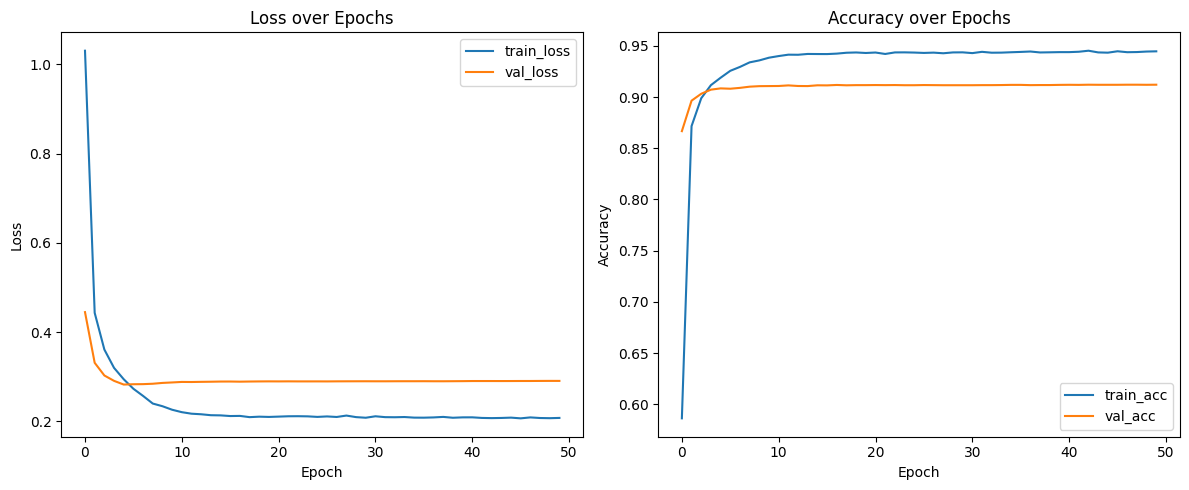

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
========== Test Set Evaluation ==========
Accuracy : 0.9129
Precision: 0.9129 | Recall: 0.9129 | F1-score: 0.9127
Confusion Matrix:
[[1707   61   86   46]
 [  19 1860   11   10]
 [  57   18 1645  180]
 [  42   25  107 1726]]


In [3]:
import os
import random
import numpy as np
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D,
    Dense, Dropout
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# ------------------------ Configuration Dataclass ------------------------
from dataclasses import dataclass

@dataclass
class Config:
    train_path: str = '/kaggle/input/ttttttttttask2/train.csv'
    test_path: str = '/kaggle/input/ttttttttttask2/test.csv'
    vocab_size: int = 15000
    max_len: int = 250
    embed_dim: int = 128
    batch_size: int = 32
    epochs: int = 50                
    seed: int = 42
    model_dir: str = 'models'
    tokenizer_dir: str = 'tokenizers'
    dropout_rate: float = 0.5
    l2_rate: float = 1e-4
    learning_rate: float = 1e-4

# ------------------------ Reproducibility ------------------------
def set_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# ------------------------ Text Cleaning ------------------------
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

# ------------------------ Data Loading & Preprocessing ------------------------
def load_and_preprocess(filepath: str, label_encoder: LabelEncoder = None):
    df = pd.read_csv(filepath)
    # 1. Combine Title & Description
    df['Text_raw'] = df['Title'].astype(str) + ' ' + df['Description'].astype(str)
    # 2. Cleaned text
    df['Text'] = df['Text_raw'].apply(clean_text)

    if label_encoder is None:
        label_encoder = LabelEncoder()
        df['Label_enc'] = label_encoder.fit_transform(df['Class Index'])
    else:
        df['Label_enc'] = label_encoder.transform(df['Class Index'])

    texts = df['Text'].tolist()
    labels = df['Label_enc'].values
    return texts, labels, label_encoder

# ------------------------ Tokenizer Preparation ------------------------
def prepare_tokenizer(texts, vocab_size: int):
    """
    Creates and fits a Keras Tokenizer on `texts`.
    """
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    return tokenizer

def texts_to_padded_sequences(tokenizer: Tokenizer, texts, max_len: int):
    """
    Converts `texts` to integer sequences, then pads/truncates to `max_len`.
    """
    seqs = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post')
    return padded

# ------------------------ Model Building ------------------------
def build_cnn_model(config: Config, num_classes: int):

    model = Sequential([
        Embedding(
            input_dim=config.vocab_size,
            output_dim=config.embed_dim
        ),
        SpatialDropout1D(config.dropout_rate),
        Conv1D(
            filters=64,                  
            kernel_size=5,
            activation='relu',
            kernel_regularizer=l2(config.l2_rate)
        ),
        GlobalMaxPooling1D(),
        Dense(
            32,                          
            activation='relu',
            kernel_regularizer=l2(config.l2_rate)
        ),
        Dropout(config.dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
        metrics=['accuracy']
    )
    return model

# ------------------------ Training Routine ------------------------
def train_model(config: Config, X_train, y_train):

    labels_flat = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels_flat),
        y=labels_flat
    )
    class_weights_dict = {i: w for i, w in enumerate(class_weights)}

    num_classes = y_train.shape[1]
    model = build_cnn_model(config, num_classes)

    os.makedirs(config.model_dir, exist_ok=True)
    checkpoint_path = os.path.join(config.model_dir, 'best_cnn_model.h5')

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=config.epochs,
        batch_size=config.batch_size,
        validation_split=0.1,
        class_weight=class_weights_dict,
        callbacks=[reduce_lr, checkpoint]
    )

    return history, checkpoint_path

# ------------------------ Evaluation Routine ------------------------
def evaluate_on_test(model_path: str, tokenizer: Tokenizer, config: Config, label_encoder: LabelEncoder):
    """
    1. Loads the best model از `model_path`.
    2. بارگذاری و پیش‌پردازش داده‌ی تست با همان label_encoder.
    3. محاسبه‌ی دقت، Precision, Recall, F1 و ماتریس درهم‌ریختگی.
    """
    # Load model
    model = tf.keras.models.load_model(model_path)

    # Load & preprocess test data
    texts_test, labels_test, _ = load_and_preprocess(config.test_path, label_encoder)
    num_classes = len(label_encoder.classes_)
    y_test = to_categorical(labels_test, num_classes=num_classes)

    X_test = texts_to_padded_sequences(tokenizer, texts_test, config.max_len)

    # Predict
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = labels_test

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    cm = confusion_matrix(y_true, y_pred)

    print("========== Test Set Evaluation ==========")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

# ------------------------ Plotting ------------------------
def plot_training(history):
    """
    رسم نمودارهای train/validation loss و accuracy.
    """
    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ------------------------ Main ------------------------
def main():
    config = Config()
    set_seeds(config.seed)

    # Create directories
    os.makedirs(config.model_dir, exist_ok=True)
    os.makedirs(config.tokenizer_dir, exist_ok=True)

    # 1. Load & preprocess train
    texts_train, labels_train, label_encoder = load_and_preprocess(
        config.train_path, label_encoder=None
    )
    num_classes = len(label_encoder.classes_)
    y_train = to_categorical(labels_train, num_classes=num_classes)

    # 2. Tokenizer & padding
    tokenizer = prepare_tokenizer(texts_train, config.vocab_size)
    X_train = texts_to_padded_sequences(tokenizer, texts_train, config.max_len)

    # 3. Save tokenizer
    tokenizer_path = os.path.join(config.tokenizer_dir, 'tokenizer.pkl')
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)

    # 4. Train model
    history, best_model_path = train_model(config, X_train, y_train)

    # 5. Plot training curves
    plot_training(history)

    # 6. Evaluate on test.csv
    evaluate_on_test(best_model_path, tokenizer, config, label_encoder)

if __name__ == '__main__':
    main()
